<module 'sys' (built-in)>
group_dict {'has_bill_shape': [0, 1, 2, 3], 'has_wing_color': [4, 5, 6, 7, 8, 9], 'has_upperparts_color': [10, 11, 12, 13, 14, 15], 'has_underparts_color': [16, 17, 18, 19, 20, 21], 'has_breast_pattern': [22, 23, 24], 'has_back_color': [25, 26, 27, 28, 29, 30], 'has_tail_shape': [31], 'has_upper_tail_color': [32, 33, 34, 35, 36], 'has_head_pattern': [37, 38], 'has_breast_color': [39, 40, 41, 42, 43, 44], 'has_throat_color': [45, 46, 47, 48, 49], 'has_eye_color': [50], 'has_bill_length': [51, 52], 'has_forehead_color': [53, 54, 55, 56, 57, 58], 'has_under_tail_color': [59, 60, 61, 62, 63], 'has_nape_color': [64, 65, 66, 67, 68, 69], 'has_belly_color': [70, 71, 72, 73, 74, 75], 'has_wing_shape': [76, 77], 'has_size': [78, 79, 80], 'has_shape': [81, 82], 'has_back_pattern': [83, 84, 85], 'has_tail_pattern': [86, 87, 88], 'has_belly_pattern': [89], 'has_primary_color': [90, 91, 92, 93, 94, 95], 'has_leg_color': [96, 97, 98], 'has_bill_color': [99, 100, 101], 'has_

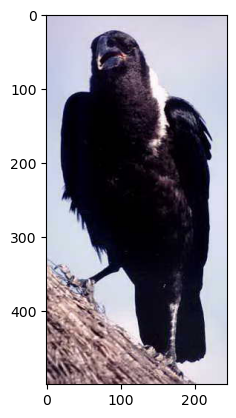

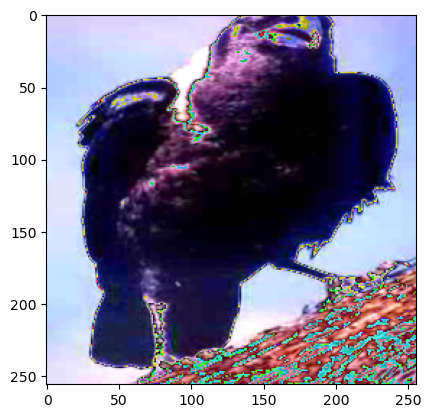

In [17]:
import torch
from torch.utils.data import DataLoader, Dataset, Sampler, BatchSampler, SubsetRandomSampler, WeightedRandomSampler
import os
import pickle
from PIL import Image
from torchvision import transforms
import argparse
import sys
sys.argv = ['example.ipynb']
import matplotlib.pyplot as plt
print(sys)

from timm.data.constants import IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD
import numpy as np
import random

class CUB_dataset(Dataset):
    def __init__(self, pkl_file, data_root, image_transforms, used_group=None) -> None:
        super().__init__()
        with  open(pkl_file, 'rb') as f:
            self.pkl = pickle.load(f)
        self.img_dir = os.path.join(data_root, 'CUB_200_2011','images')
        self.img_transforms = image_transforms
        self.n_concepts = 112
        self.n_labels = 200
        self.used_group = used_group

        attr2attrlabel = [1, 4, 6, 7, 10, 14, 15, 20, 21, 23, 25, 29, 30, 35, 36, 38, 40, 44, 45, 50, 51, 53, 54, 56, 57, 59, 63, 64, 69, 70, 72, 75, 80, 84, 90, 91,
                      93, 99, 101, 106, 110, 111, 116, 117, 119, 125, 126, 131, 132, 134, 145, 149, 151, 152, 153, 157, 158, 163, 164, 168, 172, 178, 179, 181,
                      183, 187, 188, 193, 194, 196, 198, 202, 203, 208, 209, 211, 212, 213, 218, 220, 221, 225, 235, 236, 238, 239, 240, 242, 243, 244, 249, 253,
                      254, 259, 260, 262, 268, 274, 277, 283, 289, 292, 293, 294, 298, 299, 304, 305, 308, 309, 310, 311]
        with open(os.path.join(data_root, 'attributes.txt'), 'r') as f:
            strings = f.readlines()

        # attr dict
        attr_group_dict = {}
        attr_group_dict_name = {}
        for i, idx in enumerate(attr2attrlabel):
            label = strings[idx].split(' ')[-1].replace('\n', '')
            group = label.split('::')[0]
            if group in attr_group_dict.keys():
                attr_group_dict[group].append(i)
                attr_group_dict_name[group].append(label)
            else:
                attr_group_dict[group] = [i]
                attr_group_dict_name[group] = [label]

        print('group_dict', attr_group_dict)

    def __len__(self):
        return len(self.pkl)
    
    def __getitem__(self, index):
        name = self.pkl[index]['img_path']
        # trim filename
        if 'images' in name:
            name = name.replace('/juice/scr/scr102/scr/thaonguyen/CUB_supervision/datasets/CUB_200_2011/images/' ,'')
        img_path = os.path.join(self.img_dir, name)
        image = Image.open(img_path).convert('RGB')
        print(np.array(image).shape)
        print(transforms.ToTensor()(image).size())
        plt.figure()
        plt.imshow(image)
        if self.img_transforms is not None:
            image = self.img_transforms(image)

        concept = torch.Tensor(self.pkl[index]['attribute_label'])
        class_label = torch.Tensor([self.pkl[index]['class_label']])
        concept_certainty = torch.Tensor(self.pkl[index]['attribute_certainty'])
    
        sample = {}
        sample['image'] = image
        sample['concept_label'] = concept
        sample['class_label'] = class_label
        sample['concept_certainty'] = concept_certainty
        sample['imageID'] = img_path

        return sample
    
    def get_concept_imbalance_ratio(self):
        num_attr = torch.zeros(112)
        # cocnept counts
        for data in self.pkl:
            num_attr += torch.Tensor(data['attribute_label'])
        
        imbalance_ratio = len(self.pkl) / num_attr - 1 # +1e-6
        return imbalance_ratio
    
    def get_class_imbalance_ratio(self):
        num_class = torch.zeros(200)
        # cocnept counts
        for data in self.pkl:
            num_class[data['class_label']] += 1
        
        imbalance_ratio = len(self.pkl) / num_class - 1 # +1e-6
        return imbalance_ratio

def load_data(args):
    data_root = args.dataroot
    pkl_root = args.pklroot
    batch_size = args.batch_size
    resol = args.img_size
    workers = args.workers
    # 112 used attrs by CUB, 0-indexed (https://github.com/yewsiang/ConceptBottleneck/issues/15)
    
    train_dataset, val_dataset, test_dataset = None, None, None
    drop_last = False # True?
    resized_resol = int(resol * 256 / 224) # 256?
    mean, std = IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD

    trainTransform = transforms.Compose([
        transforms.ColorJitter(brightness=32 / 255, saturation=(0.5, 1.5)), # colors with shadows, in PCBM is 0.5
        transforms.RandomHorizontalFlip(),
        transforms.Resize((resized_resol, resized_resol)),
        transforms.RandomResizedCrop(resol, scale=(0.8, 1.0)), # why? or centercrop
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
        ])

    testTransform = transforms.Compose([
        transforms.Resize((resized_resol, resized_resol)),
        transforms.CenterCrop(resol),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
        ])
    print('start constructing dataset')
    
    cub_root = os.path.join(data_root, 'CUB_200_2011')
    image_dir = os.path.join(cub_root, 'images')
    train_pkl = os.path.join(pkl_root, 'train.pkl')
    val_pkl = os.path.join(pkl_root, 'val.pkl')
    test_pkl = os.path.join(pkl_root, 'test.pkl')

    train_dataset = CUB_dataset(train_pkl, data_root, trainTransform)
    val_dataset = CUB_dataset(val_pkl, data_root, testTransform)
    test_dataset = CUB_dataset(train_pkl, data_root, testTransform)
    i = random.randint(0, 100)
    sample = train_dataset.__getitem__(i)
    print(sample['class_label'], sample['concept_label'], sample['imageID'])
    print(sample['image'].size())
    np_image = sample['image'].permute(1,2,0).numpy()
    print(np_image.shape)
    fig = plt.figure()
    plt.imshow(Image.fromarray((np_image *255).astype(np.uint8)))

    train_loader, val_loader, test_loader = None, None, None
    if train_dataset is not None:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=drop_last)
    if val_dataset is not None:
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)
    if test_dataset is not None:
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)

    return {'train': train_loader, 'val': val_loader, 'test': test_loader}, attr_group_dict

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='manual to this script')
    parser.add_argument("--dataroot", type=str, default='/home/disk/qij/CUB')
    parser.add_argument("--batch-size", type=int, default=32)
    parser.add_argument("--img-size", type=int, default=256)
    parser.add_argument("--pklroot", type=str, default='/home/disk/qij/CUB/class_attr_data_10')
    parser.add_argument('--workers', type=int, default=8)
    args = parser.parse_args()
    dataloaders, attr_group_list = load_data(args)